In [1]:
import torch

This notebook briefly demonstrates the loading and usage of the results (posteriors for global parameters and posterior moments of object-specific parameters).

## Global

The results (posteriors) for the global parameters come in the form of a `MultiSBIPosteriorPlotter` object from Clipppy, which contains (truncated) prior samples (from the validation set) and weights (likelihood-to-evidence = posterior-to-prior ratios) for different groups of parameters of interest:

In [2]:
wgplotter = torch.load('res/cigars-dindep-10000/1/wgplotter.pt', map_location='cpu', weights_only=False)

In [3]:
wgplotter.samples

<xarray.Dataset> Size: 333kB
Dimensions:             (sample: 6400)
Dimensions without coordinates: sample
Data variables: (12/13)
    step_M_logmass_loc  (sample) float32 26kB 10.53 10.93 10.17 ... 9.325 9.81
    Ode0                (sample) float32 26kB 0.6958 0.8811 ... 0.6612 0.5188
    Om0                 (sample) float32 26kB 0.2926 0.3936 ... 0.279 0.1596
    step_M_logmass      (sample) float32 26kB -0.1021 -0.08959 ... -0.03456
    dtd_s               (sample) float32 26kB -1.337 -1.316 ... -1.403 -1.317
    alpha_c             (sample) float32 26kB -0.001204 -3.758e-05 ... -0.0011
    ...                  ...
    alpha               (sample) float32 26kB -0.1321 -0.1381 ... -0.1438
    gamma_M_age         (sample) float32 26kB -0.03391 -0.03779 ... -0.03575
    M0                  (sample) float32 26kB -19.47 -19.56 ... -19.44 -19.5
    dtd_A               (sample) float32 26kB -12.14 -12.13 ... -12.18 -12.13
    sigma_res           (sample) float32 26kB 0.08657 0.1075 ... 0.1045 0.1007
    gamma_M_logzsol     (sample) float32 26kB -0.06923 -0.03721 ... -0.1035

In [4]:
wgplotter.weights.keys()

dict_keys([('Om0', 'Ode0'), ('dtd_A', 'dtd_s'), 'M0', 'sigma_res', 'alpha', 'beta', 'alpha_c', 'step_M_logmass_loc', ('step_M_logmass', 'gamma_M_logzsol'), ('step_M_logmass', 'gamma_M_age'), ('gamma_M_logzsol', 'gamma_M_age')])

In [5]:
wgplotter.weights['Om0', 'Ode0']

<xarray.DataArray (sample: 6400)> Size: 26kB
array([1.2017670e-03, 5.3027401e-05, 6.8741601e-06, ..., 2.3251001e-08,
       5.5792433e-04, 8.2029883e-10], shape=(6400,), dtype=float32)
Dimensions without coordinates: sample

These can be used to calculate posterior moments (e.g. means and standard deviations):

In [6]:
for group, weights in wgplotter.weights.items():
    group = (group,) if isinstance(group, str) else group
    print(f'Results from group {group}:')
    for param in group:
        wsamples = wgplotter.samples[param].weighted(weights)
        print(f'\t{param}: {wsamples.mean().item():.4f} ± {wsamples.std().item():.4f}')

Results from group ('Om0', 'Ode0'):
	Om0: 0.3260 ± 0.0318
	Ode0: 0.7438 ± 0.0515
Results from group ('dtd_A', 'dtd_s'):
	dtd_A: -12.1508 ± 0.0065
	dtd_s: -1.3564 ± 0.0156
Results from group ('M0',):
	M0: -19.5152 ± 0.0137
Results from group ('sigma_res',):
	sigma_res: 0.0972 ± 0.0026
Results from group ('alpha',):
	alpha: -0.1390 ± 0.0017
Results from group ('beta',):
	beta: 2.2011 ± 0.0183
Results from group ('alpha_c',):
	alpha_c: 0.0016 ± 0.0009
Results from group ('step_M_logmass_loc',):
	step_M_logmass_loc: 10.0713 ± 0.1068
Results from group ('step_M_logmass', 'gamma_M_logzsol'):
	step_M_logmass: -0.0423 ± 0.0153
	gamma_M_logzsol: -0.1156 ± 0.0148
Results from group ('step_M_logmass', 'gamma_M_age'):
	step_M_logmass: -0.0440 ± 0.0117
	gamma_M_age: -0.0303 ± 0.0017
Results from group ('gamma_M_logzsol', 'gamma_M_age'):
	gamma_M_logzsol: -0.1123 ± 0.0139
	gamma_M_age: -0.0301 ± 0.0019


or to display a weighted histogram or kernel density estimate and/or contours with one's favourite plotter. The object itself can create a nifty "corner" plot for each "group"

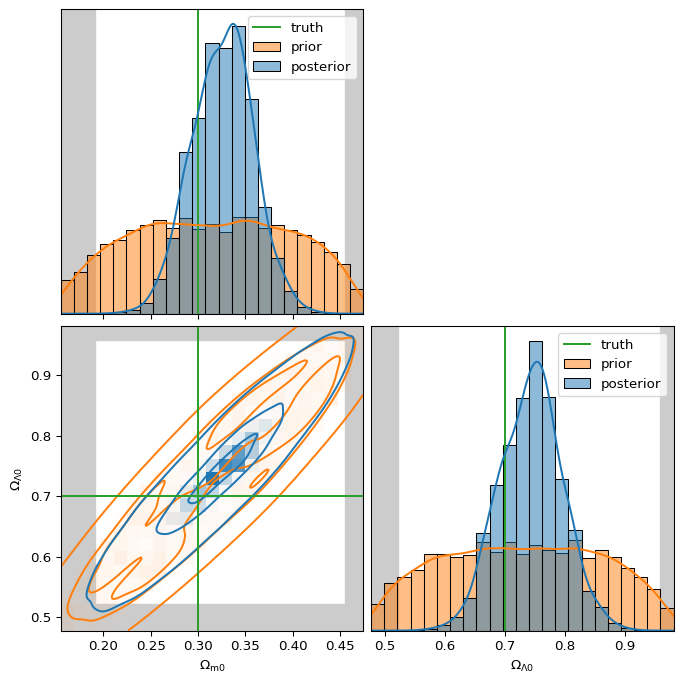

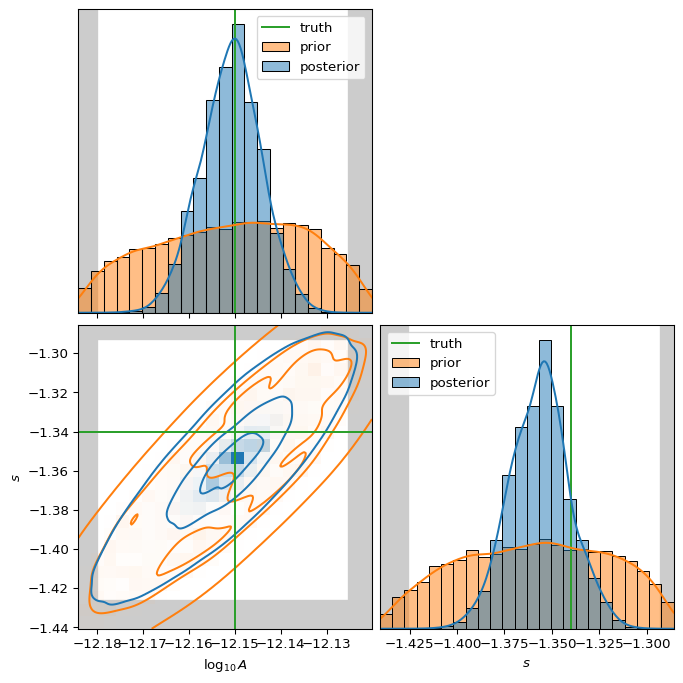

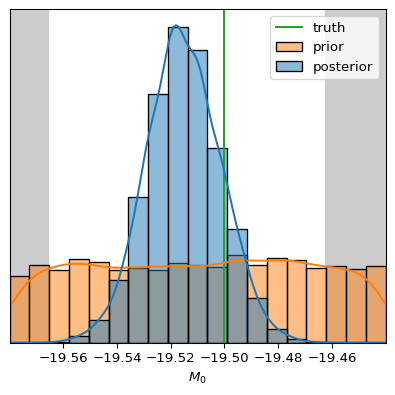

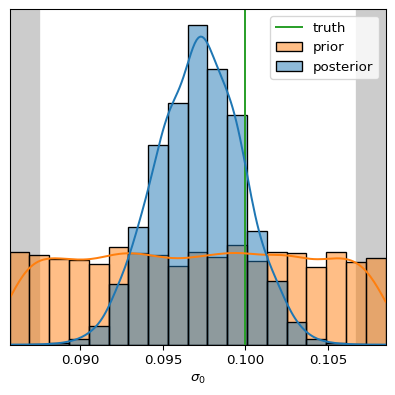

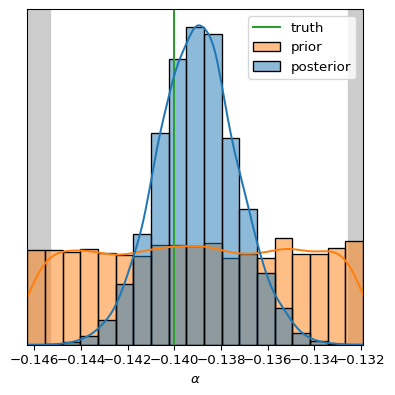

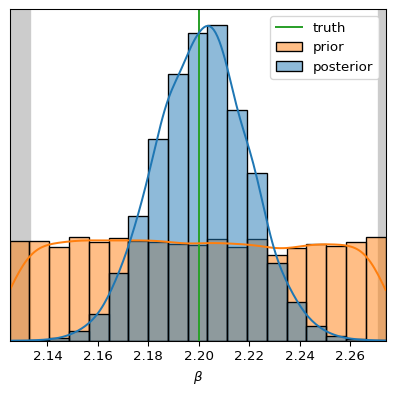

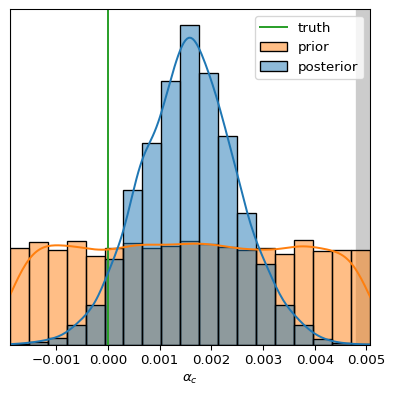

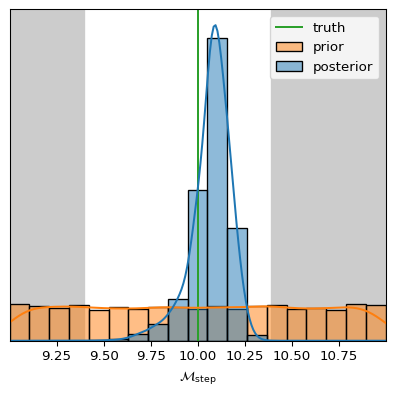

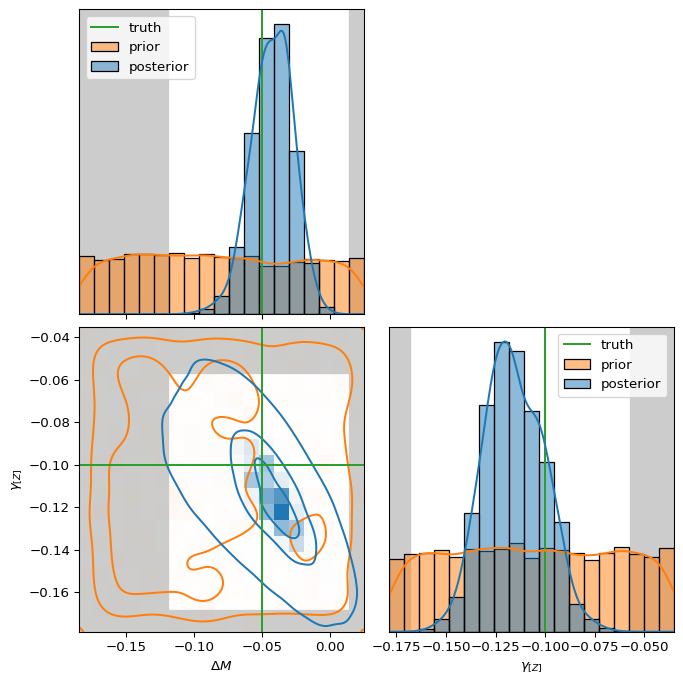

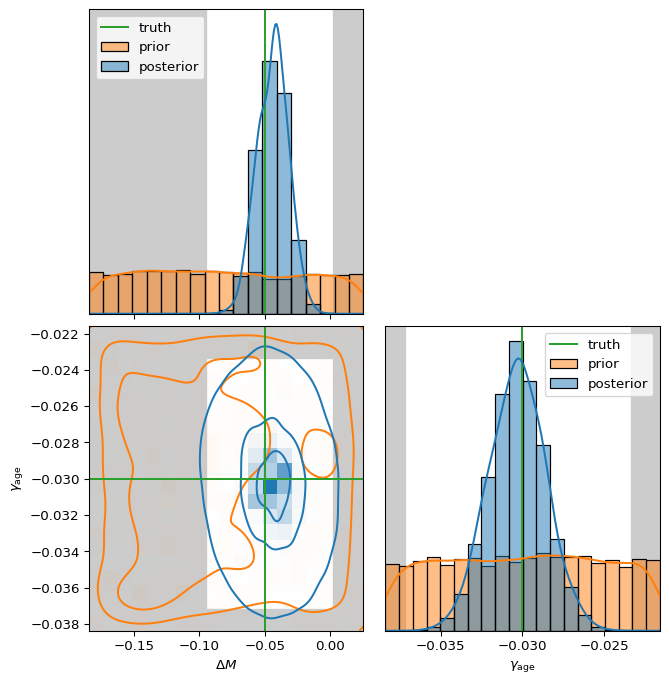

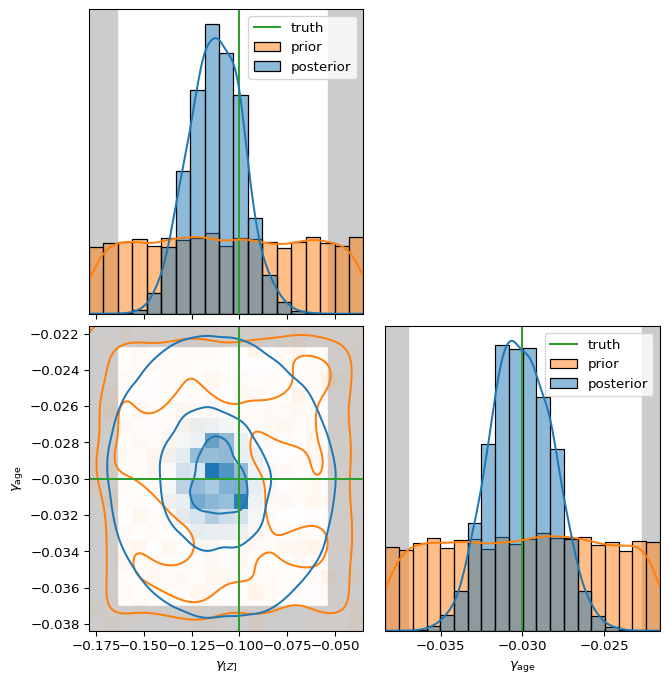

In [7]:
for group in wgplotter.weights.keys():
    wgplotter.corner(group)

The "truths" (coming from the additional information in the mock-data file) are also recorded in the `wgplotter`.

## Object-specific

We release posterior moments for local parameters of all objects in the `COUNTS=1000` data set (with ~1600 objects).

In [8]:
lpoststats = torch.load('res/cigars-dindep-1000/2/lpoststats.pt', map_location='cpu', weights_only=False)

These can be used in conjunction with the "truths" from the data file to plot a "true-vs-inferred" plot:

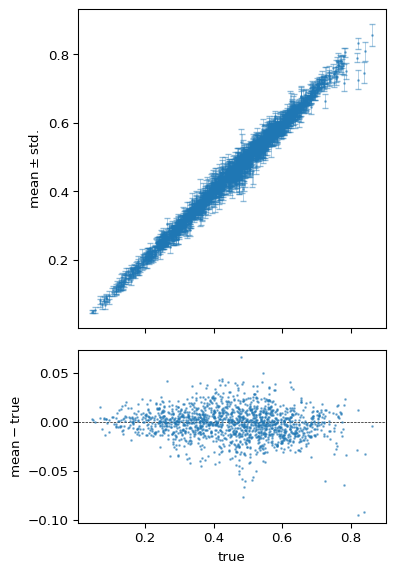

In [9]:
from matplotlib import pyplot as plt

data = torch.load('data/cigars-dindep-1000.pt', map_location='cpu', weights_only=False)

param = 'z'

truth, mean, std = data[param], lpoststats[param]['mean'], lpoststats[param]['std']

fig, axs = plt.subplots(2, 1, sharex='col', figsize=(4, 6), height_ratios=(2, 1))
axs[0].errorbar(truth, mean, std, ls='none', lw=0.5, marker='.', ms='2', alpha=0.5)

axs[1].axhline(0, color='k', ls='--', lw=0.5)
axs[1].plot(truth, mean-truth, '.', ms='2', alpha=0.5)

axs[0].set(ylabel=r'$\mathrm{mean}\pm\mathrm{std.}$', aspect='equal')
axs[1].set(xlabel='true', ylabel=r'$\mathrm{mean}-\mathrm{true}$');